#### Read counts and match with ploidy data file

This script counts the reads of every fastq file and creates an output. 

It additionally matches names and ploidy with  **CHDO_pop.csv** to make sure no descripencies

In [4]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
from os import environ
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random

In [5]:
fq_dir = '/data/gpfs/assoc/denovo/tfaske/CHDO/fastq'

In [6]:
cd $fq_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/fastq


In [7]:
fq_files = []
files = !find . -type f -name '*.F.fq.gz'
files = [os.path.abspath(x) for x in files]
for x in files:
    fq_files.append(x)
fq_files = sorted(fq_files)
len(fq_files),fq_files[0]

(614, '/data/gpfs/assoc/denovo/tfaske/CHDO/fastq/CD_AH_05.F.fq.gz')

#### Count  reads for all fq

In [8]:
fq_names = []
fq_reads = []
for f in fq_files:
    environ['f'] = f
    r = !zcat $f | awk '{s++}END{print s/4}'
    name = f.split('.F')[0]
    name = name.split('/')[8]
    #print(name)
    #print(int(r.n))
    fq_names.append(name)
    fq_reads.append(int(r.n))

In [9]:
len(fq_reads), fq_reads[:5]

(614, [743593, 1838255, 411902, 1286525, 1078635])

In [10]:
len(fq_names), fq_names[0]

(614, 'CD_AH_05')

In [11]:
read_dict = {"fq":fq_names,'reads':fq_reads}
read_df = pd.DataFrame(read_dict)
read_df.head()
#len(cov_df)

,fq,reads
0,CD_AH_05,743593
1,CD_AH_06,1838255
2,CD_AH_07,411902
3,CD_AH_08,1286525
4,CD_AH_09,1078635


In [20]:
data_dir = '/data/gpfs/assoc/denovo/tfaske/CHDO/data'

In [24]:
read_out = os.path.join(data_dir,'fq_read.csv')
read_df.to_csv(path_or_buf=read_out,index=False)

## Match fqs with CHDO_pop

Do in R

Add ploidy to known ploidy CHDO

In [22]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [29]:
%%R
require(tidyverse)
library(ggforce)
library(ggsci)
setwd('/data/gpfs/assoc/denovo/tfaske/CHDO/data')

CHDO_pop <- read.csv('CHDO_pop.csv')
read_df <- read.csv('fq_read.csv')
read_df$fq <- as.character(read_df$fq)

print(CHDO_pop[1:5,])
print(read_df[1:5,])

  Pop                 Name      Lat      Long Collector Ploidy ploidy_all
1  AH       Austin Highway 39.60081 -117.1600    Alison     NA         NA
2  AS        Austin Summit 39.47310 -117.0494    Alison     NA         NA
3  BM Bald Mountain Canyon 39.47310 -117.0494    Alison     NA         NA
4  BV          Buena Vista 43.05290 -118.8715    Alison     NA         NA
5  DC       Diamond Crator 43.07586 -118.7486    Alison     NA         NA
  Cvalue ploidy_master Bolt NoBolt Frequency
1     NA          <NA>   NA     NA        NA
2     NA          <NA>   NA     NA        NA
3     NA          <NA>   NA     NA        NA
4     NA          <NA>   NA     NA        NA
5     NA          <NA>   NA     NA        NA
        fq   reads
1 CD_AH_05  743593
2 CD_AH_06 1838255
3 CD_AH_07  411902
4 CD_AH_08 1286525
5 CD_AH_09 1078635


In [30]:
%%R 

#make ssp_pop_ID for read_df 
read_df$Sp <- sapply(read_df$fq, function(s) unlist(strsplit(as.character(s),'_'))[1])
read_df$Pop <- sapply(read_df$fq, function(s) unlist(strsplit(as.character(s),'_'))[2]) 
read_df$ID <- sapply(read_df$fq, function(s) unlist(strsplit(as.character(s),'_'))[3]) 
read_df <- read_df[,c(3,4,5,1,2)]                     
head(read_df)
                     
### change CHDO to include what we want 
                     
CHDO_pop <- CHDO_pop[,c(1,2,3,4,6)]
                      
CHDO_reads <- left_join(read_df,CHDO_pop)

R[write to console]: Joining, by = "Pop"



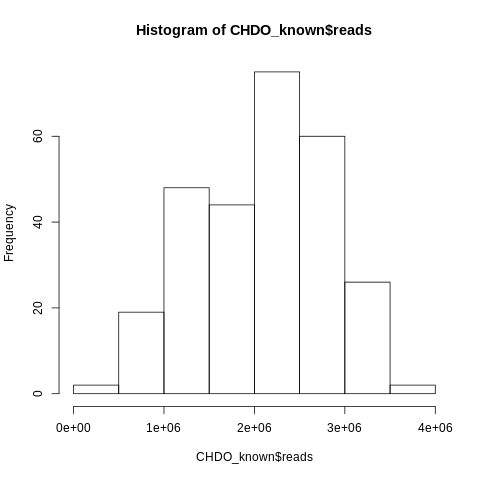

In [38]:
%%R
### Assess ploidy counts and keep only known
table(CHDO_reads$Ploidy)

### only keep known 
CHDO_known <- CHDO_reads[-which(is.na(CHDO_reads$Ploidy)),]
nrow(CHDO_known)


[1] 274


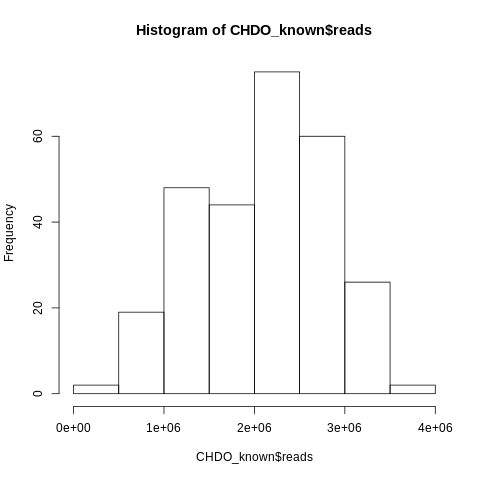

In [49]:
%%R
### Assess reads
hist(CHDO_known$reads)
summary(CHDO_known$reads)

nrow(CHDO_known)
length(which(CHDO_known$reads < 500000))
sort(CHDO_known$reads) #seems need to remove 2

#### remove smallest 2, less than 500000 reads
CHDO_known <- CHDO_known[-which(CHDO_known$reads < 500000),]
nrow(CHDO_known)

#### rename and mv to fastq_known

In [52]:
root_dir = '/data/gpfs/assoc/denovo/tfaske/CHDO/'

In [53]:
cd $root_dir

/data/gpfs/assoc/denovo/tfaske/CHDO


In [54]:
!mkdir fastq_known

In [58]:
%%R 
#rename and mv to fastq_known
CHDO_known$new_fq <- paste0(CHDO_known$Sp,CHDO_known$Ploidy,'_',
                            CHDO_known$Pop,'_',CHDO_known$ID)
CHDO_known[1:10,]
write.csv(CHDO_known,'data/CHDO_known.csv',row.names=FALSE)

### use pandas to read in and move 

In [63]:
cd $root_dir

/data/gpfs/assoc/denovo/tfaske/CHDO


In [60]:
CHDO_known = pd.read_csv('data/CHDO_known.csv')
CHDO_known.head()

,Sp,Pop,ID,fq,reads,Name,Lat,Long,Ploidy,new_fq
0,CD,AI,1,CD_AI_1,1996065,Arco Hills,43.62136,-113.22755,6,CD6_AI_1
1,CD,AI,10,CD_AI_10,3777792,Arco Hills,43.62136,-113.22755,6,CD6_AI_10
2,CD,AI,11,CD_AI_11,2538769,Arco Hills,43.62136,-113.22755,6,CD6_AI_11
3,CD,AI,2,CD_AI_2,3493929,Arco Hills,43.62136,-113.22755,6,CD6_AI_2
4,CD,AI,3,CD_AI_3,2701044,Arco Hills,43.62136,-113.22755,6,CD6_AI_3


In [64]:
for i in range(0,len(CHDO_known)):
    fq_old = 'fastq/' + CHDO_known['fq'][i] + '.F.fq.gz'
    fq_new = 'fastq_known/' + CHDO_known['new_fq'][i] + '.F.fq.gz'
    !cp $fq_old $fq_new

In [66]:
!ls -l fastq_known/*gz | wc -l 

274
